In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

In [2]:
include("utils.jl");
include("environment.jl")

draw_env! (generic function with 1 method)

In [3]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Overview

In the present notebook we model the gray highlighted part of the SLAM model (Part 2) and combine it with the sensor model from Part 1. We include the code from the 1st part in the cell below.

![slam graph 1](png/slam_graphical_model_2.png)

In [4]:
include("01_Occupancy_maps_with_sensor_model.jl");

In [5]:
function set_constraint!(target, addr, source::Gen.DynamicChoiceMap)
    Gen.set_submap!(target, addr, get_submap(source, addr))
end;

function set_constraint!(target, addr, tr::Gen.DynamicDSLTrace)     
    source = get_choices(tr)
    set_constraint!(target, addr, source)
end;

# Control and Motion

In [6]:
"Beta-like distribution over a bigger interval with prescribed mean."
@dist function my_scaled_beta(a, mean, scale)
    mean_beta = mean/scale
    b = a/mean_beta - a
    scale*beta(a,b);
end;

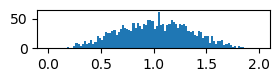

1.0109662955034153

In [7]:
a = 4.
mean_speed = 1.
max_speed = 2.
samples = [my_scaled_beta(a, mean_speed, max_speed) for t=1:2000]
# ------------------
plt.figure(figsize=(3,0.5));
plt.hist(samples, bins=0:max_speed/100:max_speed);
mean(samples)

In [8]:
"""
    Control

Contains the controls of the agent. 
"""
struct Control <: StructIterator
    "speed"
    s::Float64 
    "change of head direction"
    dhd::Float64
end;


"""
    Control(s, dhd) = control_prior(mean_speed, max_speed, sigma_dhd)

Mindlessly samples a random control vector.

Choices:
```
    |
    +-- :s : Float64
    |
    +-- :dhd : Float64
```
"""
@gen function control_model(mean_speed, max_speed, dhd_noise)
    s   ~ my_scaled_beta(4., mean_speed, max_speed)
    dhd ~ normal(0, dhd_noise)
    return Control(s, dhd)
end;
# Rem: The control model could depend on 
# ---  the current observations and the environment 

In [62]:
"""
    motion_model(pose::Pose, u::Control, hd_noise, x_noise) 

A mindless motion model for an agent that does **not** respect environmental boundaries.
That means the map argument is ignored.
"""
@gen function motion_model(pose::Pose, u::Control, hd_noise, x_noise)    
    hd ~ normal(pose.hd + u.dhd, hd_noise) 
    v = [u.s*cos(hd); u.s*sin(hd)]
    x ~ mvnormal(pose.x + v, Diagonal([x_noise, x_noise]))
    return Pose(x, hd)
end;

# Rem: The motion model could depend on the map/environment - one 
# ---  might want to check if the sampled move is in fact a valid one (see the other notebooks).

# SLAM model

In [63]:
"""
    SLAMState
"""
mutable struct SLAMState <: StructIterator
    pose::Pose 
end

"""
    slam_kernel(t::Int, 
                state::SLAMState, 
                M::Map, 
                control_args,
                motion_args,
                sensor_args)
"""
@gen function slam_kernel(t::Int, 
                          state::SLAMState, 
                          M::Map, 
                          control_args,
                          motion_args,
                          sensor_args)
    
    u     ~ control_model(control_args...)   
    pose  ~ motion_model(state.pose, u, motion_args...)
    sense ~ sensor_model(M, pose, sensor_args...)

    return SLAMState(pose)
end

slam_chain = Gen.Unfold(slam_kernel);

In [64]:
@gen function slam_model(T::Int, 
                         map_args,
                         control_args,
                         motion_args,
                         sensor_args)
    
    M  = @trace(map_prior(map_args...), :M)
    p  = @trace(pose_prior(M), :pose)
    sense = @trace(sensor_model(M, p, sensor_args...), :sense)
    
    st = @trace(slam_chain(T, SLAMState(p), M, control_args, motion_args, sensor_args), :chain)
    
    return st
end;

In [65]:
T = 1
map_args     = (map_size=(2,2), res=1., pr=0.1)
control_args = (mean_speed=1., max_speed=2., dhd_noise=0.1*2π)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=180, n=3, sig=0.1, max_val=map_args.res*max(map_args.map_size...))

tr = simulate(slam_model, (T, map_args, control_args, motion_args, sensor_args));
println(get_score(tr))
ch = get_choices(tr)

-4.567618776552858


│
├── :M
│   │
│   ├── (:m, CartesianIndex(1, 2)) : true
│   │
│   ├── (:m, CartesianIndex(2, 2)) : false
│   │
│   ├── (:m, CartesianIndex(2, 1)) : false
│   │
│   └── (:m, CartesianIndex(1, 1)) : false
│
├── :pose
│   │
│   ├── :hd : 4.12481477744977
│   │
│   └── :x : [0.0, 0.0]
│
├── :sense
│   │
│   └── :z : [2.324732878792067, 2.2006869296633202, 2.162875655423192]
│
└── :chain
    │
    └── 1
        │
        ├── :pose
        │   │
        │   ├── :hd : 4.209744682442304
        │   │
        │   └── :x : [-0.7856442030176185, -0.910809012974152]
        │
        ├── :sense
        │   │
        │   └── :z : [1.7485457224917058, 2.167817846099212, 2.142331161583448]
        │
        └── :u
            │
            ├── :s : 1.2112260157488925
            │
            └── :dhd : 0.0947195025325581


# Inference

## Load measurement and control data

In [13]:
data = load("example_sensor_data.jld")

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Dict{String,Any} with 10 entries:
  "n"       => 100
  "s"       => [1.0, 1.0, 1.0, 1.0, 1.0, 0.523099, 0.558567, 1.0, 1.0, 1.0  …  …
  "fov"     => 180
  "hd"      => [-3.02165, -3.02165, -3.14084, -2.05469, -2.67697, -1.64092, -1.…
  "env_id"  => 2010
  "x"       => [9.40075 6.33549; 8.40794 6.21583; … ; 14.0901 0.411565; 13.3557…
  "z"       => Any[[1.46981, 1.48414, 1.50488, 1.53246, 1.5675, 1.61081, 1.6634…
  "a"       => Any[[-6.16324, -6.09977, -6.03631, -5.97284, -5.90937, -5.84591,…
  "dhd"     => [0.0, -0.119195, 1.08615, -0.622273, 1.03604, 0.191485, 1.46769,…
  "max_val" => Inf

In [14]:
function set_constr!(ch, pose::Pose, t::Int64=0)
    if t==0
        ch[:pose => :x]  = pose.x
        ch[:pose => :hd] = mod(pose.hd, 2π)
    else
        ch[:chain => t => :pose => :x] = pose.x
        ch[:chain => t => :pose => :hd] = pose.hd
    end
end

function set_constr!(ch, u::Control, t::Int64)
    ch[:chain => t => :u => :s] = u.s
    ch[:chain => t => :u => :dhd] = u.dhd
end

function set_constr!(ch, sense::Measurement, t::Int64=0)
    if t==0
        ch[:sense => :z] = sense.z
    else
        ch[:chain => t => :sense => :z] = sense.z
    end
end

set_constr! (generic function with 5 methods)

In [15]:
function integrate(us::Array{Control,1}, p0::Pose)
    x, hd = p0
    xs = [x]
    for t=1:length(us)
        u = us[t]
        hd += u.dhd
        v = u.s.*[cos(hd); sin(hd)]
        x += v
        push!(xs,x)
    end
    return hcat(xs...)'
end

integrate (generic function with 1 method)

In [16]:
function extract_poses(data)
    x   = data["x"]
    hd  = data["hd"]
    T   = length(hd)
    p = [Pose(x[t,:], mod(hd[t],2π)) for t=1:T]
    
    return p
end

function extract_controls(data)
    s   = data["s"]
    dhd = data["dhd"]
    T   = length(dhd)
    u = [Control(s[t], dhd[t]) for t=1:T]
    
    return u
end

function extract_measurments(data)
    z = data["z"]
    a = data["a"]
    sen = [Measurement(z[t], a[t]) for t=1:length(a)]
    return sen
end;

function extract_sensor_args(data)
    fov = data["fov"]
    n = data["n"]
    max_val = data["max_val"]
    return (fov=fov, n=n, max_val=max_val)
end;

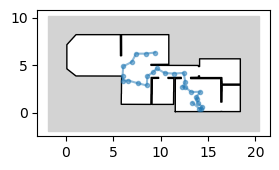

(28,)(27,)(28,)


In [17]:
env_id = data["env_id"]
env = load_env(env_id; path=p"data/HouseExpo_json");
fov, n, max_val = extract_sensor_args(data)
ps = extract_poses(data)
xs = hcat([p.x for p in ps]...)
us = extract_controls(data)
sen = extract_measurments(data)

println(size(ps), size(us), size(sen))

# -------
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);
plt.plot(xs[1,:], xs[2,:], marker=".", alpha=0.5);

## Draw

In [18]:
function draw_tr!(tr; ax=plt.gca())
    
    draw_map_circles!(tr[:M], ax=ax)
    ax.set_aspect(1)
    
    T, = get_args(tr)
    
    ps = [tr[:pose]; [tr[:chain => t => :pose] for t=1:T]...]
    
    xs = hcat([p.x for p in ps]...)
    
    sen= [tr[:sense]; [tr[:chain => t => :sense] for t=1:T]...]
    
    plt.plot(xs[1,:],xs[2,:])
    
    for t=1:length(ps)
        draw_pose!(ps[t])
        z,a = sen[t]
        b = a .+ ps[t].hd
        y = euclidean(z, b) .+ ps[t].x'
        ax.scatter(y[:,1], y[:,2], c="C1", s=2, alpha=0.5)
    
    end
end

draw_tr! (generic function with 1 method)

## Constraints

In [67]:
T = length(us)
println(T)
constr = choicemap()
set_constr!(constr, Pose([0;0], mod(ps[1].hd,2π)))
set_constr!(constr, sen[1]);
for t=1:T
    set_constr!(constr, us[t], t)  
    set_constr!(constr, sen[t+1], t)      
end

27


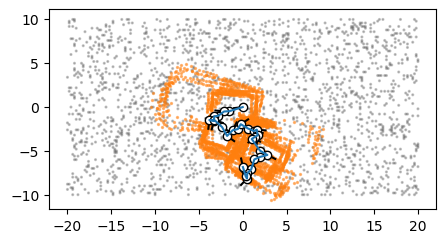

-112265.20456930625


In [68]:
map_args     = (map_size=(201,101), res=.2, pr=0.1)
control_args = (mean_speed=1., max_speed=2., dhd_noise=0.1*2π)
motion_args  = (hd_noise=0.1, x_noise=0.1)
sensor_args  = (fov=fov, n=n, sig=.2, max_val=20)

tr,w = generate(slam_model, (T, map_args, control_args, motion_args, sensor_args), constr);
println(w)
# --------
plt.figure(figsize=(5,5))
draw_tr!(tr)

## Inference

In [69]:
# @gen function f()
#     @trace(uniform(0,1), :x)
# end;

# @gen function address_wrapper(addr, model, args)
#     return @trace(model(args...), addr)
# end;

# tr = simulate(address_wrapper,(:y, f, ()))
# get_choices(tr)

In [94]:
@gen function map_proposal(tr, ell_map)
    @trace(ell_map_proposal(ell_map), :M)
end;

@gen function pose_proposal(tr, t, pose, u)
    @trace(motion_model(pose, u, motion_args...), :chain => t => :pose)
end;

In [71]:
function infer_map(tr, ell_map, steps)
    for i=1:steps
        tr,_ = metropolis_hastings(tr, map_proposal, (ell_map,))
    end
    return tr
end

infer_map (generic function with 1 method)

In [108]:
tr, w = generate(slam_model, (10, map_args, control_args, motion_args, sensor_args), choicemap());
println(w)

0.0


In [109]:
t=10
p = tr[:chain => t-1 => :pose]
u = tr[:chain => t-1 => :u]
@benchmark mh(tr, pose_proposal, (t, p, u))

BenchmarkTools.Trial: 
  memory estimate:  186.35 MiB
  allocs estimate:  429281
  --------------
  minimum time:     139.653 ms (15.58% GC)
  median time:      165.325 ms (18.40% GC)
  mean time:        165.136 ms (18.26% GC)
  maximum time:     201.719 ms (23.20% GC)
  --------------
  samples:          31
  evals/sample:     1

In [106]:
@benchmark mh(tr, select(:chain => 10 => :pose))

BenchmarkTools.Trial: 
  memory estimate:  180.00 MiB
  allocs estimate:  347660
  --------------
  minimum time:     140.070 ms (19.04% GC)
  median time:      165.363 ms (20.49% GC)
  mean time:        163.762 ms (20.23% GC)
  maximum time:     181.285 ms (20.36% GC)
  --------------
  samples:          31
  evals/sample:     1

In [47]:
tr, w = generate(slam_model, (0, map_args, control_args, motion_args, sensor_args), constr);
println(w)

M = tr[:M]
ell_map = init_map(size(M), M.res, ell(0.5))
pose  = tr[:pose]
sense = tr[:sense]
update!(ell_map, pose, sense)

tr = infer_map(tr, ell_map, 2);



for t=1:4
    new_args = (t, map_args, control_args, motion_args, sensor_args)
    argdiffs = (UnknownChange(), [NoChange() for _ in new_args[2:end]]...)
    tr, _,_,_  = update(tr, new_args, argdiffs, choicemap())
    
    for i=1:20
        tr, = mh(tr, select(:chain => t => :pose))
    end
    
#     tr, accepted = mh(tr, map_proposal, (ell_map,))
#     pose = tr[:chain => t => :pose]
#     sense = tr[:chain => t => :sense]
#     update!(ell_map, pose, sense)
end


# draw_ell_map!(ell_map,s=4)


-2461.5572808429006


InterruptException: InterruptException:

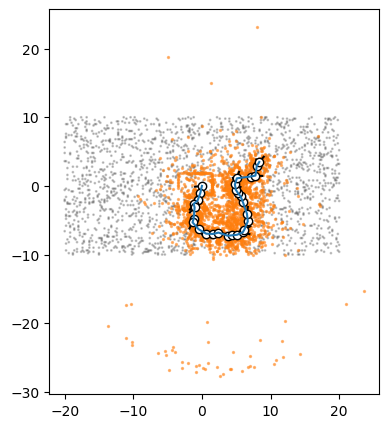

In [46]:
# --------
plt.figure(figsize=(5,5))
draw_tr!(tr)